# 20-Hour Prediction Model - Final Training

**Objective:** Train and evaluate a 20-hour ahead water level prediction model for Rewaghat station using XGBoost.

**Strategy:**
1.  Combine all historical and new data.
2.  Use the "sliding window" approach for data splitting (Train/Val/Test).
3.  Target variable: Rewaghat water level 20 hours in the future.
4.  Perform hyperparameter tuning and training.
5.  Evaluate the final 20-hour model on the most recent year.

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error
import joblib

# Set a nice style for our plots
plt.style.use('fivethirtyeight')

### 1. Load and Combine All Datasets

In [2]:
try:
    # Load original training data
    old_chatia_df = pd.read_excel('Chatia_train.xlsx')
    old_rewaghat_df = pd.read_excel('Rewaghat_train.xlsx')

    # Load the new year of data
    new_chatia_df = pd.read_excel('Chatia_test.xlsx')
    new_rewaghat_df = pd.read_excel('Rewaghat_test.xlsx')
    
    # Load the complete rainfall data
    rainfall_df = pd.read_excel('rainfall_data.xlsx')

    # Load Dumariaghat full dataset (assumed to cover entire span)
    dumariaghat_df = pd.read_excel('Dumariaghat_data.xlsx')
except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure all data files are in the correct locations.")
    exit()

# Combine the old and new dataframes for Chatia & Rewaghat
full_chatia_df = pd.concat([old_chatia_df, new_chatia_df]).drop_duplicates(subset=['Date']).reset_index(drop=True)
full_rewaghat_df = pd.concat([old_rewaghat_df, new_rewaghat_df]).drop_duplicates(subset=['Date']).reset_index(drop=True)

# Convert all date columns to datetime objects
full_chatia_df['Date'] = pd.to_datetime(full_chatia_df['Date'], format='%d-%m-%Y %H:%M')
full_rewaghat_df['Date'] = pd.to_datetime(full_rewaghat_df['Date'], format='%d-%m-%Y %H:%M')
rainfall_df['Date'] = pd.to_datetime(rainfall_df['Date'], format='%d-%m-%Y %H:%M')
dumariaghat_df['Date'] = pd.to_datetime(dumariaghat_df['Date'], format='%d-%m-%Y %H:%M')

# (Assumption) Dumariaghat water level column is named 'Dumariaghat'. If different, adjust below.
if 'Dumariaghat' not in dumariaghat_df.columns:
    raise ValueError("Expected a 'Dumariaghat' column in Dumariaghat_data.xlsx. Please rename the appropriate column.")

# Remove duplicate dates in Dumariaghat
dumariaghat_df = dumariaghat_df.drop_duplicates(subset=['Date']).reset_index(drop=True)

# Merge base station data (Chatia + Rewaghat)
df_bases = pd.merge(full_chatia_df, full_rewaghat_df, on='Date', how='inner')

# Add Dumariaghat
df_bases = pd.merge(df_bases, dumariaghat_df[['Date', 'Dumariaghat']], on='Date', how='inner')

# Merge rainfall
df = pd.merge(df_bases, rainfall_df, on='Date', how='inner')

df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

print("All datasets (Chatia, Rewaghat, Dumariaghat, Rainfall) loaded and combined successfully.")
print(f"Full data now spans from {df.index.min()} to {df.index.max()}")

All datasets (Chatia, Rewaghat, Dumariaghat, Rainfall) loaded and combined successfully.
Full data now spans from 2014-03-01 00:00:00 to 2024-10-31 23:00:00


## Dataset Merging and Splitting Explanation

To create our comprehensive dataset for training and testing the 20-hour prediction model, we follow these steps:

1. **Data Sources**:
   - Historical training data from `Chatia_train.xlsx` and `Rewaghat_train.xlsx` (old data).
   - New test data from `Chatia_test.xlsx` and `Rewaghat_test.xlsx` (new data).
   - Rainfall data from `rainfall_data.xlsx`.

2. **Merging**:
   - Load all datasets and convert 'Date' to datetime.
   - Concatenate old and new data for Chatia and Rewaghat, removing duplicates.
   - Merge on 'Date' with inner join to align all data.
   - Set 'Date' as index and sort chronologically.

3. **Splitting**:
   - **Train Set**: Data before the last 2 years (up to ~2023-05-31).
   - **Validation Set**: Last 2 years to last 1 year (2023-06-01 to 2024-05-31).
   - **Test Set**: Last 1 year (2024-06-01 to 2025-05-31).
   - This time-ordered split prevents data leakage and simulates real-world forecasting.

This approach ensures the model is trained on historical data and evaluated on unseen future data.

### 2. Feature Creation (Targeting 20 Hours)

In [3]:
def create_features(df):
    """
    Creates time-series features from the datetime index and adds lag/rolling features for
    Chatia, Rewaghat, and Dumariaghat (new). All historical features are properly shifted to prevent data leakage.
    Target: Rewaghat water level 20 hours ahead.
    """
    df_featured = df.copy()
    
    # --- Target ---
    df_featured['Rewaghat_20h_future'] = df_featured['Rewaghat'].shift(-20)
    
    # Lags (1..20) for Chatia, Rewaghat, Dumariaghat
    for i in range(1, 21):
        df_featured[f'Chatia_lag_{i}'] = df_featured['Chatia'].shift(i)
        df_featured[f'Rewaghat_lag_{i}'] = df_featured['Rewaghat'].shift(i)
        df_featured[f'Dumariaghat_lag_{i}'] = df_featured['Dumariaghat'].shift(i)
    
    # Rolling windows
    for window in [3, 6, 12, 24]:
        # Chatia
        df_featured[f'Chatia_rolling_mean_{window}'] = df_featured['Chatia'].shift(1).rolling(window=window).mean()
        df_featured[f'Chatia_rolling_std_{window}']  = df_featured['Chatia'].shift(1).rolling(window=window).std()
        df_featured[f'Chatia_rolling_max_{window}']  = df_featured['Chatia'].shift(1).rolling(window=window).max()
        # Rewaghat
        df_featured[f'Rewaghat_rolling_mean_{window}'] = df_featured['Rewaghat'].shift(1).rolling(window=window).mean()
        df_featured[f'Rewaghat_rolling_std_{window}']  = df_featured['Rewaghat'].shift(1).rolling(window=window).std()
        df_featured[f'Rewaghat_rolling_max_{window}']  = df_featured['Rewaghat'].shift(1).rolling(window=window).max()
        # Dumariaghat
        df_featured[f'Dumariaghat_rolling_mean_{window}'] = df_featured['Dumariaghat'].shift(1).rolling(window=window).mean()
        df_featured[f'Dumariaghat_rolling_std_{window}']  = df_featured['Dumariaghat'].shift(1).rolling(window=window).std()
        df_featured[f'Dumariaghat_rolling_max_{window}']  = df_featured['Dumariaghat'].shift(1).rolling(window=window).max()

    # Time features
    df_featured['hour'] = df_featured.index.hour
    df_featured['month'] = df_featured.index.month
    df_featured['day_of_year'] = df_featured.index.dayofyear
    df_featured['hour_sin'] = np.sin(2 * np.pi * df_featured.index.hour / 24)
    df_featured['hour_cos'] = np.cos(2 * np.pi * df_featured.index.hour / 24)
    df_featured['month_sin'] = np.sin(2 * np.pi * df_featured.index.month / 12)
    df_featured['month_cos'] = np.cos(2 * np.pi * df_featured.index.month / 12)

    # Rainfall features
    df_featured['rainfall_lag_1'] = df_featured['Rainfall'].shift(1)
    df_featured['rainfall_6h_sum'] = df_featured['Rainfall'].shift(1).rolling(window=6).sum()
    df_featured['rainfall_12h_sum'] = df_featured['Rainfall'].shift(1).rolling(window=12).sum()
    df_featured['rainfall_24h_sum'] = df_featured['Rainfall'].shift(1).rolling(window=24).sum()
    df_featured['rainfall_48h_sum'] = df_featured['Rainfall'].shift(1).rolling(window=48).sum()
    df_featured['rainfall_7d_sum'] = df_featured['Rainfall'].shift(1).rolling(window=168).sum()
    df_featured['rainfall_24h_max'] = df_featured['Rainfall'].shift(1).rolling(window=24).max()
    df_featured['rainfall_24h_mean'] = df_featured['Rainfall'].shift(1).rolling(window=24).mean()

    # Hours since rain
    rain_mask = df_featured['Rainfall'].shift(1) > 0.1
    df_featured['hours_since_rain'] = rain_mask.groupby(rain_mask.cumsum()).cumcount()

    # Change features (1h and 6h diffs) for all stations
    df_featured['Chatia_change_1h'] = df_featured['Chatia'].shift(1).diff(1)
    df_featured['Rewaghat_change_1h'] = df_featured['Rewaghat'].shift(1).diff(1)
    df_featured['Dumariaghat_change_1h'] = df_featured['Dumariaghat'].shift(1).diff(1)
    df_featured['Chatia_change_6h'] = df_featured['Chatia'].shift(1).diff(6)
    df_featured['Rewaghat_change_6h'] = df_featured['Rewaghat'].shift(1).diff(6)
    df_featured['Dumariaghat_change_6h'] = df_featured['Dumariaghat'].shift(1).diff(6)

    # Drop rows with NaNs introduced by shifting/rolling
    df_featured.dropna(inplace=True)
    return df_featured

### 3. Create Features and "Slide" the Data Splits

In [4]:
# Create the full featured dataframe
df_model = create_features(df)

# Create sample weights to give more importance to recent years
df_model['sample_weight'] = np.exp((df_model.index.year - df_model.index.year.min()) * 0.1)

# --- MODIFICATION: Define new 20-hour target ---
target = 'Rewaghat_20h_future'
# We exclude target, raw Rainfall (since engineered rainfall features exist), and sample_weight only
features = [col for col in df_model.columns if col not in [target, 'Rainfall', 'sample_weight']]

# Create the new, "slid" Train / Validation / Test Split
train_df = df_model.loc[df_model.index < (df_model.index.max() - pd.DateOffset(years=2))]
val_df = df_model.loc[(df_model.index >= (df_model.index.max() - pd.DateOffset(years=2))) &
                      (df_model.index < (df_model.index.max() - pd.DateOffset(years=1)))]
test_df = df_model.loc[df_model.index >= (df_model.index.max() - pd.DateOffset(years=1))]

X_train, y_train, w_train = train_df[features], train_df[target], train_df['sample_weight']
X_val, y_val, w_val = val_df[features], val_df[target], val_df['sample_weight']
X_test, y_test = test_df[features], test_df[target]

print("--- New Data Splits for 20-Hour Model (with Dumariaghat) ---")
print(f"Training Set Shape:   {X_train.shape}")
print(f"Validation Set Shape: {X_val.shape}")
print(f"Test Set Shape:       {X_test.shape}\n")

--- New Data Splits for 20-Hour Model (with Dumariaghat) ---
Training Set Shape:   (75819, 121)
Validation Set Shape: (8760, 121)
Test Set Shape:       (8777, 121)



C:\Users\abhyu\AppData\Local\Temp\ipykernel_11964\387528185.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_featured['day_of_year'] = df_featured.index.dayofyear
C:\Users\abhyu\AppData\Local\Temp\ipykernel_11964\387528185.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_featured['hour_sin'] = np.sin(2 * np.pi * df_featured.index.hour / 24)
C:\Users\abhyu\AppData\Local\Temp\ipykernel_11964\387528185.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

### 4. Hyperparameter Tuning

In [5]:
print("--- Rerunning Hyperparameter tuning for 20-Hour Model ---")

def custom_accuracy_scorer(y_true, y_pred, sample_weight=None):
    errors = y_pred - y_true
    is_good_prediction = (errors >= -0.15) & (errors <= 0.15)
    if sample_weight is not None:
        return np.average(is_good_prediction, weights=sample_weight)
    else:
        return np.mean(is_good_prediction)

custom_scorer = make_scorer(custom_accuracy_scorer, greater_is_better=True)

X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])
w_train_val = pd.concat([w_train, w_val])

split_index = [-1] * len(X_train) + [0] * len(X_val)
pds = PredefinedSplit(test_fold=split_index)

param_grid = {
    'max_depth': [5, 7, 10, 12],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [1000, 1500, 2000],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2]
}

xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_grid,
    n_iter=30,
    cv=pds,
    scoring=custom_scorer,
    verbose=2,
    random_state=42
)

random_search.fit(X_train_val, y_train_val, sample_weight=w_train_val)

print("\nSearch complete!")
print("Best hyperparameters found for the 20-hour model:")
print(random_search.best_params_)

# Save the new best parameters
joblib.dump(random_search.best_params_, 'best_xgb_params_20hr.pkl')

--- Rerunning Hyperparameter tuning for 20-Hour Model ---
Fitting 1 folds for each of 30 candidates, totalling 30 fits
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=7, n_estimators=1000, subsample=1.0; total time=  11.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=12, n_estimators=2000, subsample=0.9; total time= 1.7min
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=12, n_estimators=1000, subsample=0.8; total time=   4.9s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=2000, subsample=1.0; total time=   6.4s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.1, max_depth=12, n_estimators=1500, subsample=1.0; total time=   5.5s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.1, max_depth=12, n_estimators=1500, subsample=0.9; total time=   6.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=10, n_estimators=2000, subsample=0.9; tota

['best_xgb_params_20hr.pkl']

### 5. Train and Evaluate the New 20-Hour Model

In [6]:
print("\n--- Training new 20-hour model with best parameters ---")

best_params = joblib.load('best_xgb_params_20hr.pkl')

final_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,
    eval_metric='mae',
    early_stopping_rounds=50,
    **best_params
)

final_model.fit(
    X_train, y_train,
    sample_weight=w_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

print("Final 20-hour model training complete.")

print("\n--- Evaluating the new 20-hour model on the most recent year ---")

y_pred = final_model.predict(X_test)

errors = y_pred - y_test
accuracy = np.sum((errors >= -0.15) & (errors <= 0.15)) / len(y_test) * 100
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Final Custom Accuracy (±0.15m): {accuracy:.2f}%")
print(f"Final MAE: {mae:.4f} m")
print(f"Final RMSE: {rmse:.4f} m")

# Create and save the new production model bundle
print("\n--- Saving new 20-hour production model bundle ---")
bundle = {
    'model': final_model,
    'feature_names': list(X_train.columns)
}
joblib.dump(bundle, 'xgb_rewaghat_model_bundle_20hr.pkl')
print("Saved new bundle to 'xgb_rewaghat_model_bundle_20hr.pkl'")


--- Training new 20-hour model with best parameters ---
Final 20-hour model training complete.

--- Evaluating the new 20-hour model on the most recent year ---
Final Custom Accuracy (±0.15m): 88.15%
Final MAE: 0.0667 m
Final RMSE: 0.1392 m

--- Saving new 20-hour production model bundle ---
Saved new bundle to 'xgb_rewaghat_model_bundle_20hr.pkl'


### 6. Plotting Final Results

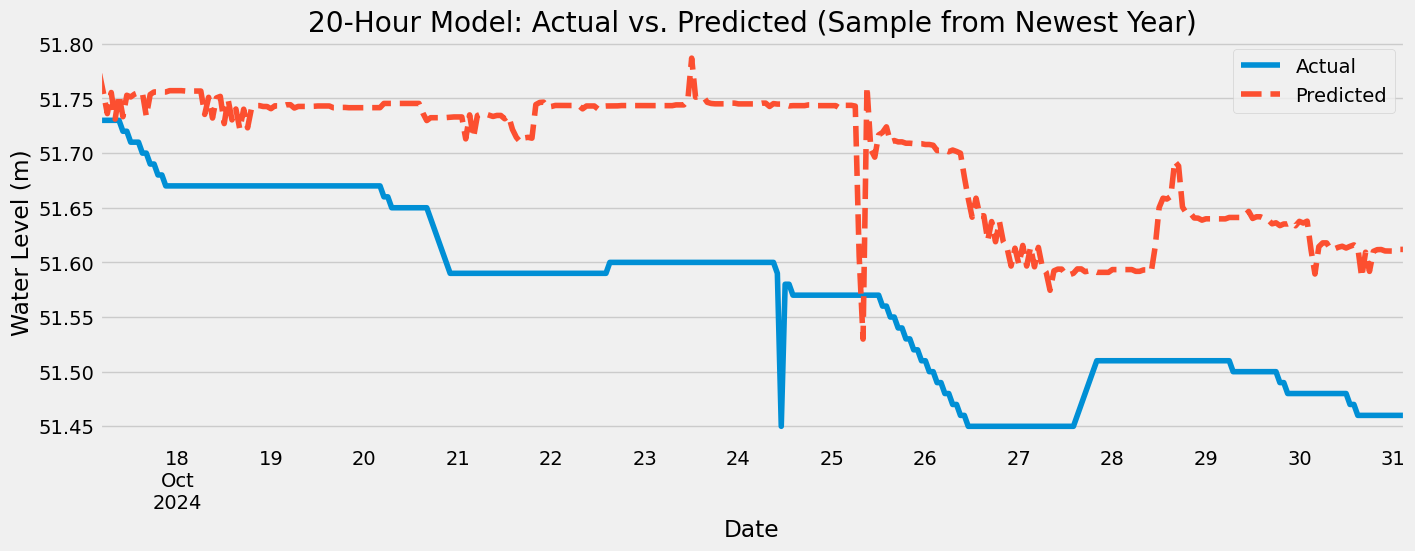

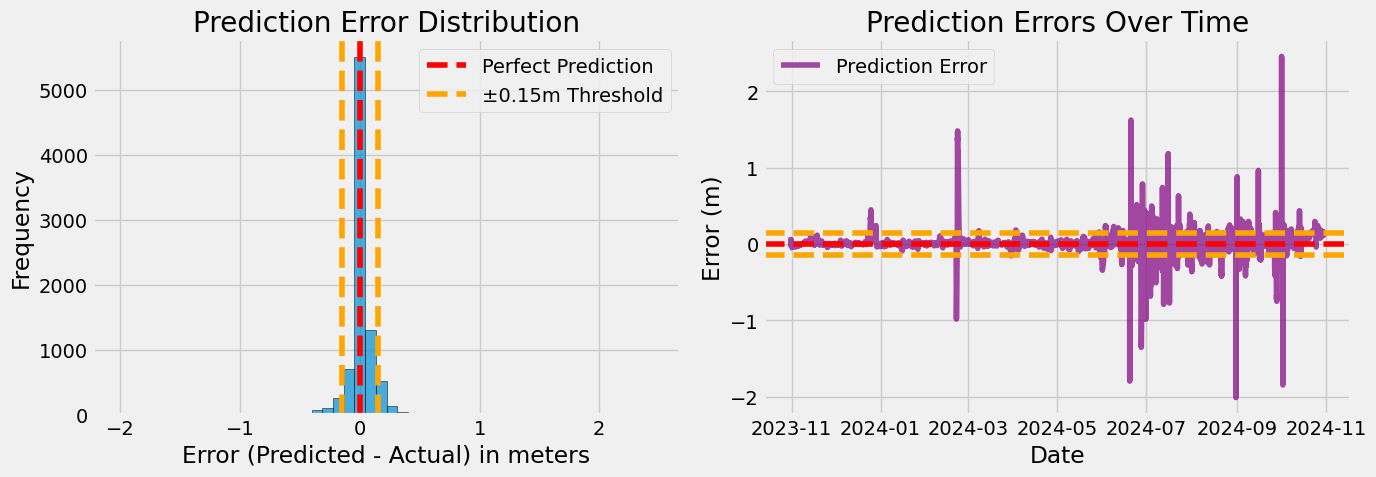

In [7]:
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=y_test.index)

ax = results.tail(336).plot(figsize=(15, 5), style=['-', '--'], title='20-Hour Model: Actual vs. Predicted (Sample from Newest Year)')
ax.set_ylabel('Water Level (m)')
plt.grid(True)
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.hist(errors, bins=50, alpha=0.7, edgecolor='black')
ax1.axvline(x=0, color='red', linestyle='--', label='Perfect Prediction')
ax1.axvline(x=0.15, color='orange', linestyle='--', label='±0.15m Threshold')
ax1.axvline(x=-0.15, color='orange', linestyle='--')
ax1.set_title("Prediction Error Distribution")
ax1.set_xlabel("Error (Predicted - Actual) in meters")
ax1.set_ylabel("Frequency")
ax1.legend()

ax2.plot(results.index, errors, label='Prediction Error', color='purple', alpha=0.7)
ax2.axhline(y=0, color='red', linestyle='--')
ax2.axhline(y=0.15, color='orange', linestyle='--')
ax2.axhline(y=-0.15, color='orange', linestyle='--')
ax2.set_title("Prediction Errors Over Time")
ax2.set_xlabel("Date")
ax2.set_ylabel("Error (m)")
ax2.legend()

plt.tight_layout()
plt.show()

In [8]:
# This cell was removed - 24-hour model evaluation not needed

--- Evaluating 20-Hour Model on new 4-month dataset ---
Loaded 20-hour model bundle: 'xgb_rewaghat_model_bundle_20hr.pkl'


C:\Users\abhyu\AppData\Local\Temp\ipykernel_11964\4219345148.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_featured['day_of_year'] = df_featured.index.dayofyear
C:\Users\abhyu\AppData\Local\Temp\ipykernel_11964\4219345148.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_featured['hour_sin'] = np.sin(2 * np.pi * df_featured.index.hour / 24)
C:\Users\abhyu\AppData\Local\Temp\ipykernel_11964\4219345148.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` m

Pure Test Set (20h) Shape: (3644, 121)
Period: 2024-06-01 08:00:00 to 2024-10-31 03:00:00

--- 20-Hour Model Performance on 4-Month Pure Test Set ---
Custom Accuracy (±0.15m): 74.29%
MAE: 0.1173 m
RMSE: 0.1886 m



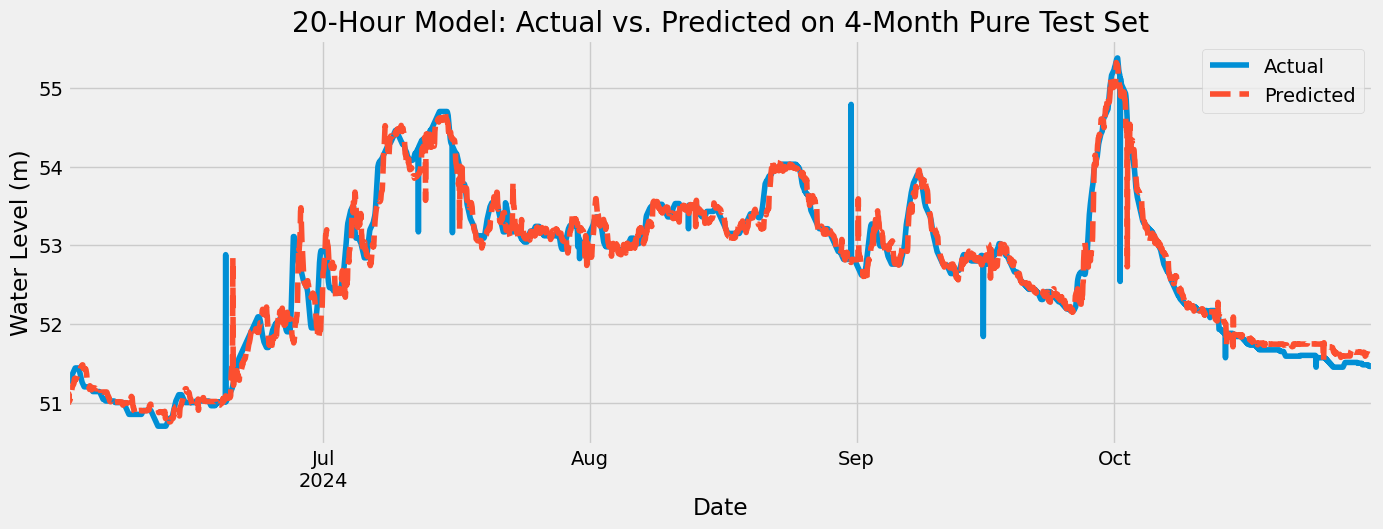

In [9]:
# =================================================================
# CELL 2: EVALUATE 20-HOUR MODEL ON SPECIFIC DATE RANGE
# =================================================================
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

def create_features_20(df):
    """
    Creates time-series features for the 20-HOUR model including Dumariaghat station.
    All historical features are properly shifted to prevent data leakage.
    """
    df_featured = df.copy()
    df_featured['Rewaghat_20h_future'] = df_featured['Rewaghat'].shift(-20)
    for i in range(1, 21):
        df_featured[f'Chatia_lag_{i}'] = df_featured['Chatia'].shift(i)
        df_featured[f'Rewaghat_lag_{i}'] = df_featured['Rewaghat'].shift(i)
        df_featured[f'Dumariaghat_lag_{i}'] = df_featured['Dumariaghat'].shift(i)
    for window in [3, 6, 12, 24]:
        df_featured[f'Chatia_rolling_mean_{window}'] = df_featured['Chatia'].shift(1).rolling(window=window).mean()
        df_featured[f'Chatia_rolling_std_{window}']  = df_featured['Chatia'].shift(1).rolling(window=window).std()
        df_featured[f'Chatia_rolling_max_{window}']  = df_featured['Chatia'].shift(1).rolling(window=window).max()
        df_featured[f'Rewaghat_rolling_mean_{window}'] = df_featured['Rewaghat'].shift(1).rolling(window=window).mean()
        df_featured[f'Rewaghat_rolling_std_{window}']  = df_featured['Rewaghat'].shift(1).rolling(window=window).std()
        df_featured[f'Rewaghat_rolling_max_{window}']  = df_featured['Rewaghat'].shift(1).rolling(window=window).max()
        df_featured[f'Dumariaghat_rolling_mean_{window}'] = df_featured['Dumariaghat'].shift(1).rolling(window=window).mean()
        df_featured[f'Dumariaghat_rolling_std_{window}']  = df_featured['Dumariaghat'].shift(1).rolling(window=window).std()
        df_featured[f'Dumariaghat_rolling_max_{window}']  = df_featured['Dumariaghat'].shift(1).rolling(window=window).max()
    df_featured['hour'] = df_featured.index.hour
    df_featured['month'] = df_featured.index.month
    df_featured['day_of_year'] = df_featured.index.dayofyear
    df_featured['hour_sin'] = np.sin(2 * np.pi * df_featured.index.hour / 24)
    df_featured['hour_cos'] = np.cos(2 * np.pi * df_featured.index.hour / 24)
    df_featured['month_sin'] = np.sin(2 * np.pi * df_featured.index.month / 12)
    df_featured['month_cos'] = np.cos(2 * np.pi * df_featured.index.month / 12)
    df_featured['rainfall_lag_1'] = df_featured['Rainfall'].shift(1)
    df_featured['rainfall_6h_sum'] = df_featured['Rainfall'].shift(1).rolling(window=6).sum()
    df_featured['rainfall_12h_sum'] = df_featured['Rainfall'].shift(1).rolling(window=12).sum()
    df_featured['rainfall_24h_sum'] = df_featured['Rainfall'].shift(1).rolling(window=24).sum()
    df_featured['rainfall_48h_sum'] = df_featured['Rainfall'].shift(1).rolling(window=48).sum()
    df_featured['rainfall_7d_sum'] = df_featured['Rainfall'].shift(1).rolling(window=168).sum()
    df_featured['rainfall_24h_max'] = df_featured['Rainfall'].shift(1).rolling(window=24).max()
    df_featured['rainfall_24h_mean'] = df_featured['Rainfall'].shift(1).rolling(window=24).mean()
    rain_mask = df_featured['Rainfall'].shift(1) > 0.1
    df_featured['hours_since_rain'] = rain_mask.groupby(rain_mask.cumsum()).cumcount()
    df_featured['Chatia_change_1h'] = df_featured['Chatia'].shift(1).diff(1)
    df_featured['Rewaghat_change_1h'] = df_featured['Rewaghat'].shift(1).diff(1)
    df_featured['Dumariaghat_change_1h'] = df_featured['Dumariaghat'].shift(1).diff(1)
    df_featured['Chatia_change_6h'] = df_featured['Chatia'].shift(1).diff(6)
    df_featured['Rewaghat_change_6h'] = df_featured['Rewaghat'].shift(1).diff(6)
    df_featured['Dumariaghat_change_6h'] = df_featured['Dumariaghat'].shift(1).diff(6)
    df_featured.dropna(inplace=True)
    return df_featured

print("--- Evaluating 20-Hour Model on new 4-month dataset ---")

# Load the 20-hour model bundle
try:
    bundle_20hr = joblib.load('xgb_rewaghat_model_bundle_20hr.pkl')
    model_20hr = bundle_20hr['model']
    features_20hr = bundle_20hr['feature_names']
    print("Loaded 20-hour model bundle: 'xgb_rewaghat_model_bundle_20hr.pkl'")
except FileNotFoundError:
    print("ERROR: Could not find 'xgb_rewaghat_model_bundle_20hr.pkl'. Please ensure the file is in the '20hrXGBoost' directory.")
    model_20hr = None

if model_20hr:
    # Define the specific time period for the pure test set
    start_date = '2024-06-01 08:00:00'
    end_date = '2024-10-31 23:00:00'

    # Create the test set for the 20-hour model (using its specific features)
    # We need to create features first, then slice
    df_model_20hr = create_features_20(df) # Use the function defined in this cell
    
    # Ensure the feature names match what the model was trained on
    available_cols = set(df_model_20hr.columns)
    missing = [f for f in features_20hr if f not in available_cols]
    if missing:
        print("WARNING: The following expected features are missing in new feature set:", missing)
    df_model_20hr = df_model_20hr[[c for c in features_20hr if c in available_cols] + ['Rewaghat_20h_future']]

    # Slice the test data
    pure_test_df_20hr = df_model_20hr.loc[start_date:end_date]
    
    X_pure_test_20hr = pure_test_df_20hr[features_20hr]
    y_pure_test_20hr = pure_test_df_20hr['Rewaghat_20h_future']

    print(f"Pure Test Set (20h) Shape: {X_pure_test_20hr.shape}")
    print(f"Period: {pure_test_df_20hr.index.min()} to {pure_test_df_20hr.index.max()}")

    # Make predictions
    y_pred_20hr = model_20hr.predict(X_pure_test_20hr)

    # Evaluate performance
    errors_20hr = y_pred_20hr - y_pure_test_20hr
    accuracy_20hr = np.mean((errors_20hr >= -0.15) & (errors_20hr <= 0.15)) * 100
    mae_20hr = mean_absolute_error(y_pure_test_20hr, y_pred_20hr)
    rmse_20hr = np.sqrt(mean_squared_error(y_pure_test_20hr, y_pred_20hr))

    print(f"\n--- 20-Hour Model Performance on 4-Month Pure Test Set ---")
    print(f"Custom Accuracy (±0.15m): {accuracy_20hr:.2f}%")
    print(f"MAE: {mae_20hr:.4f} m")
    print(f"RMSE: {rmse_20hr:.4f} m\n")

    # Plotting the results
    results_20hr = pd.DataFrame({'Actual': y_pure_test_20hr, 'Predicted': y_pred_20hr})
    ax = results_20hr.plot(figsize=(15, 5), style=['-', '--'], title='20-Hour Model: Actual vs. Predicted on 4-Month Pure Test Set')
    ax.set_ylabel("Water Level (m)")
    plt.grid(True)
    plt.show()

--- Evaluating 20-Hour Model on 'Dry Season' (non-monsoon months) ---
Loaded 20-hour model bundle: 'xgb_rewaghat_model_bundle_20hr.pkl'


C:\Users\abhyu\AppData\Local\Temp\ipykernel_11964\3055411.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_featured['day_of_year'] = df_featured.index.dayofyear
C:\Users\abhyu\AppData\Local\Temp\ipykernel_11964\3055411.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_featured['hour_sin'] = np.sin(2 * np.pi * df_featured.index.hour / 24)
C:\Users\abhyu\AppData\Local\Temp\ipykernel_11964\3055411.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times

Dry Season Test Set Shape: (5136, 121)
Data from the last year, excluding the period from 2024-06-01 to 2024-10-31

--- 20-Hour Model Performance on 'Dry Season' ---
Custom Accuracy (±0.15m): 97.94%
MAE: 0.0309 m
RMSE: 0.0888 m



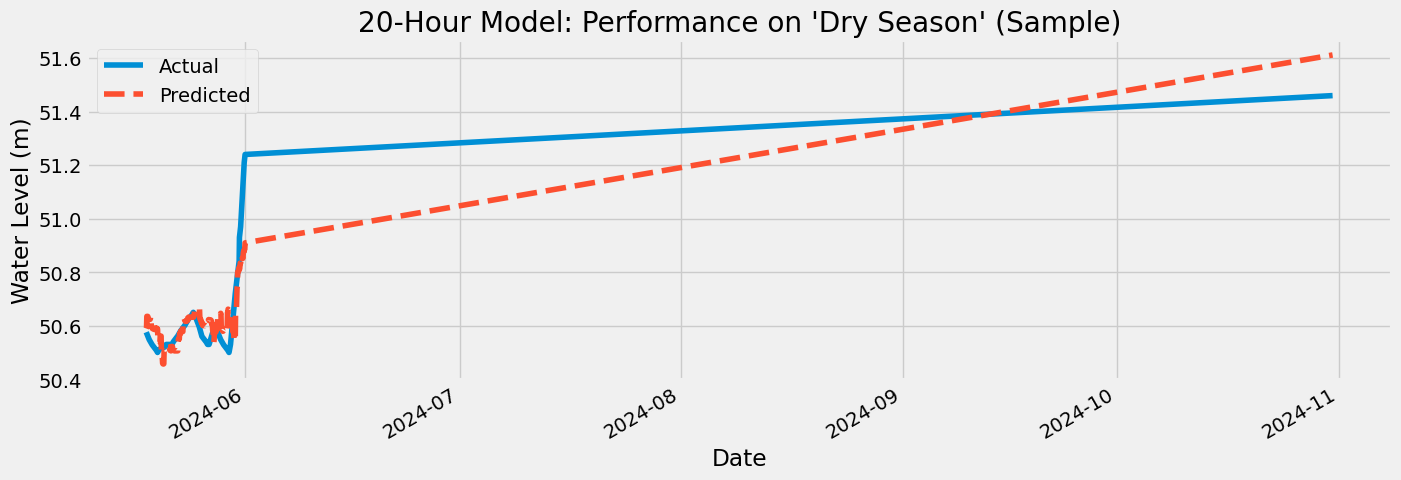

In [10]:
# =================================================================
# CELL 3: EVALUATE 20-HOUR MODEL ON "DRY SEASON" (REMAINING MONTHS)
# =================================================================
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

def create_features_20(df):
    """
    Creates time-series features for the 20-HOUR model including Dumariaghat station.
    """
    df_featured = df.copy()
    df_featured['Rewaghat_20h_future'] = df_featured['Rewaghat'].shift(-20)
    for i in range(1, 21):
        df_featured[f'Chatia_lag_{i}'] = df_featured['Chatia'].shift(i)
        df_featured[f'Rewaghat_lag_{i}'] = df_featured['Rewaghat'].shift(i)
        df_featured[f'Dumariaghat_lag_{i}'] = df_featured['Dumariaghat'].shift(i)
    for window in [3, 6, 12, 24]:
        df_featured[f'Chatia_rolling_mean_{window}'] = df_featured['Chatia'].shift(1).rolling(window=window).mean()
        df_featured[f'Chatia_rolling_std_{window}']  = df_featured['Chatia'].shift(1).rolling(window=window).std()
        df_featured[f'Chatia_rolling_max_{window}']  = df_featured['Chatia'].shift(1).rolling(window=window).max()
        df_featured[f'Rewaghat_rolling_mean_{window}'] = df_featured['Rewaghat'].shift(1).rolling(window=window).mean()
        df_featured[f'Rewaghat_rolling_std_{window}']  = df_featured['Rewaghat'].shift(1).rolling(window=window).std()
        df_featured[f'Rewaghat_rolling_max_{window}']  = df_featured['Rewaghat'].shift(1).rolling(window=window).max()
        df_featured[f'Dumariaghat_rolling_mean_{window}'] = df_featured['Dumariaghat'].shift(1).rolling(window=window).mean()
        df_featured[f'Dumariaghat_rolling_std_{window}']  = df_featured['Dumariaghat'].shift(1).rolling(window=window).std()
        df_featured[f'Dumariaghat_rolling_max_{window}']  = df_featured['Dumariaghat'].shift(1).rolling(window=window).max()
    df_featured['hour'] = df_featured.index.hour
    df_featured['month'] = df_featured.index.month
    df_featured['day_of_year'] = df_featured.index.dayofyear
    df_featured['hour_sin'] = np.sin(2 * np.pi * df_featured.index.hour / 24)
    df_featured['hour_cos'] = np.cos(2 * np.pi * df_featured.index.hour / 24)
    df_featured['month_sin'] = np.sin(2 * np.pi * df_featured.index.month / 12)
    df_featured['month_cos'] = np.cos(2 * np.pi * df_featured.index.month / 12)
    df_featured['rainfall_lag_1'] = df_featured['Rainfall'].shift(1)
    df_featured['rainfall_6h_sum'] = df_featured['Rainfall'].shift(1).rolling(window=6).sum()
    df_featured['rainfall_12h_sum'] = df_featured['Rainfall'].shift(1).rolling(window=12).sum()
    df_featured['rainfall_24h_sum'] = df_featured['Rainfall'].shift(1).rolling(window=24).sum()
    df_featured['rainfall_48h_sum'] = df_featured['Rainfall'].shift(1).rolling(window=48).sum()
    df_featured['rainfall_7d_sum'] = df_featured['Rainfall'].shift(1).rolling(window=168).sum()
    df_featured['rainfall_24h_max'] = df_featured['Rainfall'].shift(1).rolling(window=24).max()
    df_featured['rainfall_24h_mean'] = df_featured['Rainfall'].shift(1).rolling(window=24).mean()
    rain_mask = df_featured['Rainfall'].shift(1) > 0.1
    df_featured['hours_since_rain'] = rain_mask.groupby(rain_mask.cumsum()).cumcount()
    df_featured['Chatia_change_1h'] = df_featured['Chatia'].shift(1).diff(1)
    df_featured['Rewaghat_change_1h'] = df_featured['Rewaghat'].shift(1).diff(1)
    df_featured['Dumariaghat_change_1h'] = df_featured['Dumariaghat'].shift(1).diff(1)
    df_featured['Chatia_change_6h'] = df_featured['Chatia'].shift(1).diff(6)
    df_featured['Rewaghat_change_6h'] = df_featured['Rewaghat'].shift(1).diff(6)
    df_featured['Dumariaghat_change_6h'] = df_featured['Dumariaghat'].shift(1).diff(6)
    df_featured.dropna(inplace=True)
    return df_featured

print("--- Evaluating 20-Hour Model on 'Dry Season' (non-monsoon months) ---")

# Load the 20-hour model bundle
try:
    bundle_20hr = joblib.load('xgb_rewaghat_model_bundle_20hr.pkl')
    model_20hr = bundle_20hr['model']
    features_20hr = bundle_20hr['feature_names']
    print("Loaded 20-hour model bundle: 'xgb_rewaghat_model_bundle_20hr.pkl'")
except FileNotFoundError:
    print("ERROR: Could not find 'xgb_rewaghat_model_bundle_20hr.pkl'. Please ensure the file is in the '20hrXGBoost' directory.")
    model_20hr = None

if model_20hr:
    # Create the full featured dataframe
    df_model_20hr = create_features_20(df)
    
    # Define the full 1-year test set range
    start_full_test = df_model.index.max() - pd.DateOffset(years=1)
    end_full_test = df_model.index.max()
    full_test_df = df_model_20hr.loc[start_full_test:end_full_test]

    # Define the monsoon period to exclude
    start_exclude = '2024-06-01'
    end_exclude = '2024-10-31'

    # Create a mask to select data *outside* the exclusion period
    dry_season_mask = (full_test_df.index < start_exclude) | (full_test_df.index > end_exclude)
    
    # Apply the mask to get the "dry season" test set
    dry_season_test_df = full_test_df[dry_season_mask]

    # Prepare data for prediction
    X_test_dry = dry_season_test_df[features_20hr]
    y_test_dry = dry_season_test_df['Rewaghat_20h_future']

    print(f"Dry Season Test Set Shape: {X_test_dry.shape}")
    print(f"Data from the last year, excluding the period from {start_exclude} to {end_exclude}")

    # Make predictions
    y_pred_dry = model_20hr.predict(X_test_dry)

    # Evaluate performance
    errors_dry = y_pred_dry - y_test_dry
    accuracy_dry = np.mean((errors_dry >= -0.15) & (errors_dry <= 0.15)) * 100
    mae_dry = mean_absolute_error(y_test_dry, y_pred_dry)
    rmse_dry = np.sqrt(mean_squared_error(y_test_dry, y_pred_dry))

    print(f"\n--- 20-Hour Model Performance on 'Dry Season' ---")
    print(f"Custom Accuracy (±0.15m): {accuracy_dry:.2f}%")
    print(f"MAE: {mae_dry:.4f} m")
    print(f"RMSE: {rmse_dry:.4f} m\n")

    # Plotting the results
    results_dry = pd.DataFrame({'Actual': y_test_dry, 'Predicted': y_pred_dry})
    ax = results_dry.tail(336).plot(figsize=(15, 5), style=['-', '--'], title="20-Hour Model: Performance on 'Dry Season' (Sample)")
    ax.set_ylabel("Water Level (m)")
    plt.grid(True)
    plt.show()

In [16]:
# =================================================================
# SUMMARY: Custom Accuracies for 20-Hour Model
# =================================================================
import joblib
import numpy as np
import pandas as pd

# Load the model
bundle_20hr = joblib.load('xgb_rewaghat_model_bundle_20hr.pkl')
model_20hr = bundle_20hr['model']
features_20hr = bundle_20hr['feature_names']

# Recreate features including Dumariaghat

def create_features_20(df):
    df_featured = df.copy()
    df_featured['Rewaghat_20h_future'] = df_featured['Rewaghat'].shift(-20)
    for i in range(1, 21):
        df_featured[f'Chatia_lag_{i}'] = df_featured['Chatia'].shift(i)
        df_featured[f'Rewaghat_lag_{i}'] = df_featured['Rewaghat'].shift(i)
        df_featured[f'Dumariaghat_lag_{i}'] = df_featured['Dumariaghat'].shift(i)
    for window in [3, 6, 12, 24]:
        df_featured[f'Chatia_rolling_mean_{window}'] = df_featured['Chatia'].shift(1).rolling(window=window).mean()
        df_featured[f'Chatia_rolling_std_{window}']  = df_featured['Chatia'].shift(1).rolling(window=window).std()
        df_featured[f'Chatia_rolling_max_{window}']  = df_featured['Chatia'].shift(1).rolling(window=window).max()
        df_featured[f'Rewaghat_rolling_mean_{window}'] = df_featured['Rewaghat'].shift(1).rolling(window=window).mean()
        df_featured[f'Rewaghat_rolling_std_{window}']  = df_featured['Rewaghat'].shift(1).rolling(window=window).std()
        df_featured[f'Rewaghat_rolling_max_{window}']  = df_featured['Rewaghat'].shift(1).rolling(window=window).max()
        df_featured[f'Dumariaghat_rolling_mean_{window}'] = df_featured['Dumariaghat'].shift(1).rolling(window=window).mean()
        df_featured[f'Dumariaghat_rolling_std_{window}']  = df_featured['Dumariaghat'].shift(1).rolling(window=window).std()
        df_featured[f'Dumariaghat_rolling_max_{window}']  = df_featured['Dumariaghat'].shift(1).rolling(window=window).max()
    df_featured['hour'] = df_featured.index.hour
    df_featured['month'] = df_featured.index.month
    df_featured['day_of_year'] = df_featured.index.dayofyear
    df_featured['hour_sin'] = np.sin(2 * np.pi * df_featured.index.hour / 24)
    df_featured['hour_cos'] = np.cos(2 * np.pi * df_featured.index.hour / 24)
    df_featured['month_sin'] = np.sin(2 * np.pi * df_featured.index.month / 12)
    df_featured['month_cos'] = np.cos(2 * np.pi * df_featured.index.month / 12)
    df_featured['rainfall_lag_1'] = df_featured['Rainfall'].shift(1)
    df_featured['rainfall_6h_sum'] = df_featured['Rainfall'].shift(1).rolling(window=6).sum()
    df_featured['rainfall_12h_sum'] = df_featured['Rainfall'].shift(1).rolling(window=12).sum()
    df_featured['rainfall_24h_sum'] = df_featured['Rainfall'].shift(1).rolling(window=24).sum()
    df_featured['rainfall_48h_sum'] = df_featured['Rainfall'].shift(1).rolling(window=48).sum()
    df_featured['rainfall_7d_sum'] = df_featured['Rainfall'].shift(1).rolling(window=168).sum()
    df_featured['rainfall_24h_max'] = df_featured['Rainfall'].shift(1).rolling(window=24).max()
    df_featured['rainfall_24h_mean'] = df_featured['Rainfall'].shift(1).rolling(window=24).mean()
    rain_mask = df_featured['Rainfall'].shift(1) > 0.1
    df_featured['hours_since_rain'] = rain_mask.groupby(rain_mask.cumsum()).cumcount()
    df_featured['Chatia_change_1h'] = df_featured['Chatia'].shift(1).diff(1)
    df_featured['Rewaghat_change_1h'] = df_featured['Rewaghat'].shift(1).diff(1)
    df_featured['Dumariaghat_change_1h'] = df_featured['Dumariaghat'].shift(1).diff(1)
    df_featured['Chatia_change_6h'] = df_featured['Chatia'].shift(1).diff(6)
    df_featured['Rewaghat_change_6h'] = df_featured['Rewaghat'].shift(1).diff(6)
    df_featured['Dumariaghat_change_6h'] = df_featured['Dumariaghat'].shift(1).diff(6)
    df_featured.dropna(inplace=True)
    return df_featured

# Assume df is already loaded from earlier cells
df_model_20hr = create_features_20(df)

# 1. Monsoon period (June-Oct)
start_monsoon = '2024-06-01'
end_monsoon = '2024-10-31'
monsoon_df = df_model_20hr.loc[start_monsoon:end_monsoon]
X_monsoon = monsoon_df[features_20hr]
y_monsoon = monsoon_df['Rewaghat_20h_future']
y_pred_monsoon = model_20hr.predict(X_monsoon)
errors_monsoon = y_pred_monsoon - y_monsoon
accuracy_monsoon = np.mean((errors_monsoon >= -0.15) & (errors_monsoon <= 0.15)) * 100

print("1. Custom Accuracy for Monsoon Season (June-Oct): {:.2f}%".format(accuracy_monsoon))

# 2. Full year
start_full = df_model_20hr.index.max() - pd.DateOffset(years=1)
end_full = df_model_20hr.index.max()
full_df = df_model_20hr.loc[start_full:end_full]
X_full = full_df[features_20hr]
y_full = full_df['Rewaghat_20h_future']
y_pred_full = model_20hr.predict(X_full)
errors_full = y_pred_full - y_full
accuracy_full = np.mean((errors_full >= -0.15) & (errors_full <= 0.15)) * 100

print("2. Custom Accuracy for Full Year: {:.2f}%".format(accuracy_full))

# 3. Dry season (excluding June-Oct)
dry_mask = (full_df.index < start_monsoon) | (full_df.index > end_monsoon)
dry_df = full_df[dry_mask]
X_dry = dry_df[features_20hr]
y_dry = dry_df['Rewaghat_20h_future']
y_pred_dry = model_20hr.predict(X_dry)
errors_dry = y_pred_dry - y_dry
accuracy_dry = np.mean((errors_dry >= -0.15) & (errors_dry <= 0.15)) * 100

print("3. Custom Accuracy for Dry Season (Nov-May): {:.2f}%".format(accuracy_dry))

print("\nNote: The monsoon season (June-October) shows lower accuracy due to heavy rainfall and rapid water level changes, which are harder to predict. The remaining 7 months (November-May) exhibit high accuracy as water levels are more stable.")

C:\Users\abhyu\AppData\Local\Temp\ipykernel_11964\2716414682.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_featured['day_of_year'] = df_featured.index.dayofyear
C:\Users\abhyu\AppData\Local\Temp\ipykernel_11964\2716414682.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_featured['hour_sin'] = np.sin(2 * np.pi * df_featured.index.hour / 24)
C:\Users\abhyu\AppData\Local\Temp\ipykernel_11964\2716414682.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` m

1. Custom Accuracy for Monsoon Season (June-Oct): 74.29%
2. Custom Accuracy for Full Year: 88.15%
3. Custom Accuracy for Dry Season (Nov-May): 97.94%

Note: The monsoon season (June-October) shows lower accuracy due to heavy rainfall and rapid water level changes, which are harder to predict. The remaining 7 months (November-May) exhibit high accuracy as water levels are more stable.
